In [1]:
# Import all the necessary libraries
import pandas as pd
import os 
import glob
import numpy as np
from scipy import stats
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read all csv files in directory
csv_files = glob.glob('*.{}'.format('csv'))
csv_files

['Test 4.csv', 'Test 5.csv', 'Test 2.csv', 'Test 3.csv', 'Test 1.csv']

In [4]:
# Create a dataframe by combining all 5 csv files 
df1 = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [5]:
# AS null values are negligiable in count so dropping all the null values
df1.dropna(inplace=True)

In [6]:
# Converting date columns into Pandas DateTime format
date_cols = df1.columns[10:14]
df1[date_cols] = df1[date_cols].apply(pd.to_datetime, errors='coerce')

In [7]:
# Creating new colummn which shows Usage Month (difference between Registration Date and Repair date in months)
df1['USAGE_MONTHS'] = round((df1['REPAIR_DATE'] - df1['FCOK_DATE']) / np.timedelta64(1, 'M'))

<AxesSubplot:>

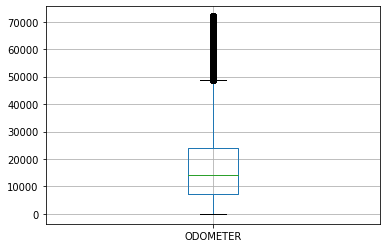

In [8]:
# Create a boxplot for odometer (outlier detection)
df1.boxplot(column = ['ODOMETER'])

In [9]:
# We did 98% quqntile analysis 
df1.quantile(0.98)

ODOMETER        39800.0
USAGE_MONTHS       27.0
Name: 0.98, dtype: float64

In [10]:
# After EDA we found out 98% odometer reading are under 40000 so removing values greter than 40000
df2 = df1[df1['ODOMETER'] <= 40000]

<AxesSubplot:>

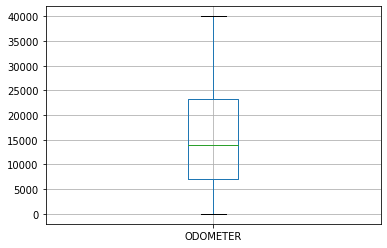

In [11]:
# Creating a boxplot for odometer (no outlier)
df2.boxplot(column = ['ODOMETER'])

<AxesSubplot:>

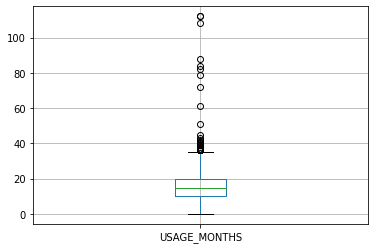

In [12]:
# Creating a boxplot for usage months (outlier detection)
df2.boxplot(column = ['USAGE_MONTHS'])

In [13]:
# Removing extreme value in usage months
df3 = df2[df2['USAGE_MONTHS'] <= 28]

<AxesSubplot:>

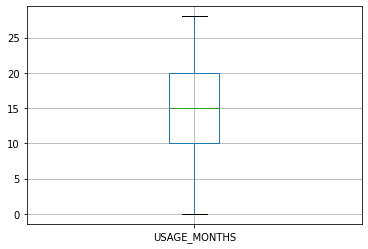

In [14]:
# Creating a boxplot for odometer (no outlier)
df3.boxplot(column = ['USAGE_MONTHS'])

In [15]:
# Converting float usage months values into integers
df3["USAGE_MONTHS"] = df3["USAGE_MONTHS"].astype(int)

In [16]:
# Converting usage month into bins(categories) and storing this into new variable target
df3['target'] = pd.cut(df2['USAGE_MONTHS'], bins=[0,3,6,12,29], 
                          labels=['1', '2', '3', '0'])

In [17]:
# Dropping null values
df3.dropna(inplace = True)

In [18]:
# Dropping unnecessary columns
df4 = df3.drop(['CITY','VEND_CODE','FCOK_DATE','REGD_DATE', 
           'PROCESSING_DATE', 'REGION'], axis = 1)

In [19]:
# Mapping Fuel Type into 0 and 1
df4['Fuel Type'] = df4['Fuel Type'].map({'DIESEL MODELS':0, 'PETROL MODELS':1})

In [20]:
# Renaming column for ease
df4.rename(columns = {'Fuel Type':'petrol','Part Name':'part', 'Model':'model',
                       'Attribution code':'code','ODOMETER':'odometer','Section':'section',
                      'PLANT_CODE':'plant','REPAIR_DATE':'faultdate','USAGE_MONTHS':'usage'}, inplace = True)

In [21]:
# Encoding all the categorical variavles into numerical
from sklearn.preprocessing import LabelEncoder
le_part = LabelEncoder()
le_code = LabelEncoder()
le_model = LabelEncoder()
le_section = LabelEncoder()
le_plant = LabelEncoder()

df4['part'] = le_part.fit_transform(df4['part'])
df4['code'] = le_code.fit_transform(df4['code'])
df4['model'] = le_model.fit_transform(df4['model'])
df4['section'] = le_section.fit_transform(df4['section'])
df4['plant'] = le_plant.fit_transform(df4['plant'])

In [22]:
# Creating an new feature faultmonth from faultdate for plotting purpose
df4['faultmonth'] = df4['faultdate'].dt.to_period('M')

In [23]:
# Sorting the Values by faultdate
df4.sort_values(by='faultdate', inplace = True)

In [24]:
# Resetting Index
df4.reset_index(inplace = True)
df4.drop(['index','faultdate'], axis=1, inplace = True)

In [28]:
df4.describe()

,part,code,model,petrol,section,odometer,plant,usage
count,136335.000000,136335.000000,136335.000000,136335.000000,136335.000000,136335.000000,136335.000000,136335.000000
mean,11.175656,3.283148,8.159152,0.793465,4.744475,15952.705798,2.577497,14.811787
std,8.160103,1.323785,5.889122,0.404821,2.419431,10508.969083,1.814414,6.547104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,4.000000,4.000000,1.000000,3.000000,7046.000000,1.000000,10.000000
50%,11.000000,4.000000,6.000000,1.000000,5.000000,13955.000000,3.000000,15.000000
75%,19.000000,4.000000,13.000000,1.000000,7.000000,23177.000000,4.000000,20.000000
max,24.000000,4.000000,22.000000,1.000000,8.000000,40000.000000,7.000000,28.000000


In [30]:
# Splitting data into main and validation set
df = df4.iloc[:100000,:]
df_val = df4.iloc[100000:,:]

In [33]:
# Creating input and target dataset from validation set
X_val = df_val.drop(['faultmonth', 'target', 'part', 'petrol' ,'usage', 'odometer'], axis=1)
y_val = df_val['part']

In [35]:
# Creating different dataframe for 3M, 6M, and 12M analysis
df_3M = df[df['target'] == '1']
df_6M = df[df['target'] == '2']
df_12M = df[df['target'] == '3']

In [36]:
# Creating an input and output dataset
X = df.drop(['faultmonth', 'target', 'part', 'petrol' ,'usage', 'odometer'], axis=1)
y = df['part']
X.head(3)

,code,model,section,plant
0,4,8,8,1
1,1,1,8,0
2,4,0,7,0


In [37]:
# Splitting the model into train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)

In [38]:
# Calculating model accuracy based on model score (Ussed RandomForest after comapring with other models)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.7758

In [39]:
# Determing the feature importance using mutual information 
#I have used all the columns initaially and chose the important ones
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.29519303, 0.84798286, 1.94054954, 0.45292138])

In [40]:
# Using validation dataset
rf.score(X_val,y_val)

0.6988578505573139

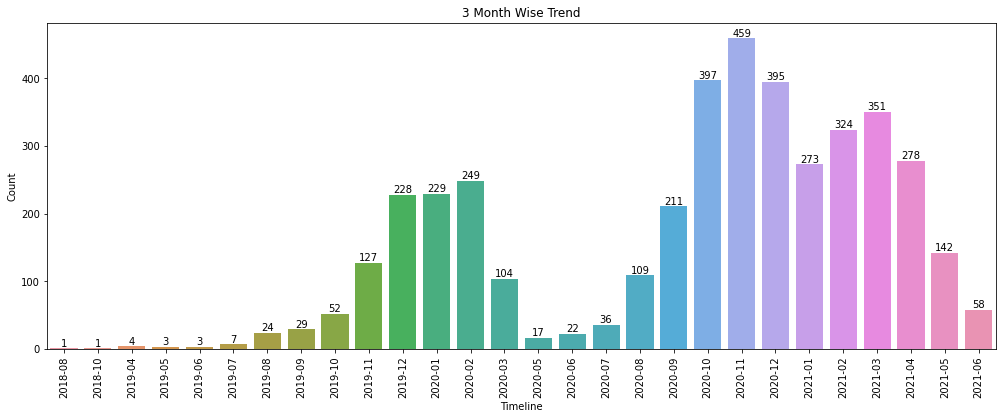

In [41]:
# Plotting 3M trend
plt.figure(figsize=(17,6))

graph = sns.countplot(x ='faultmonth', data = df_3M)
graph.bar_label(graph.containers[0])

plt.xticks(rotation=90, horizontalalignment="center")
plt.title("3 Month Wise Trend")
plt.xlabel("Timeline")

plt.ylabel("Count")
plt.show()

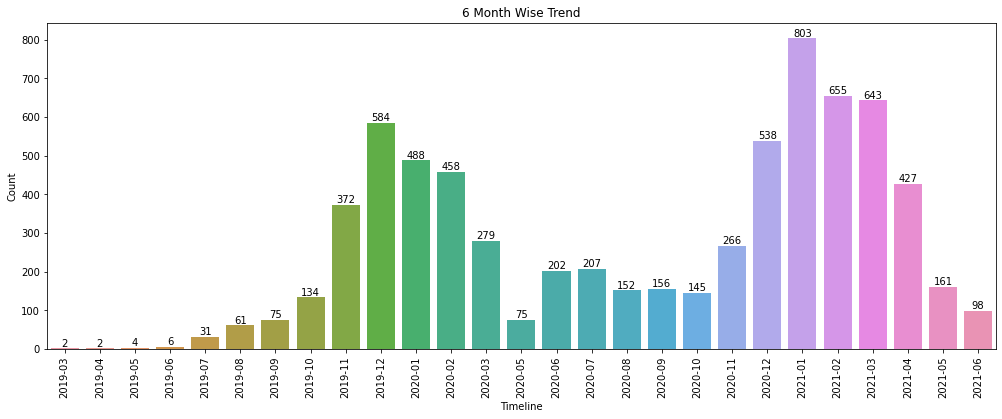

In [42]:
# Plotting 6M trend
plt.figure(figsize=(17,6))

graph = sns.countplot(x ='faultmonth', data = df_6M)
graph.bar_label(graph.containers[0])

plt.xticks(rotation=90, horizontalalignment="center")
plt.title("6 Month Wise Trend")
plt.xlabel("Timeline")

plt.ylabel("Count")
plt.show()

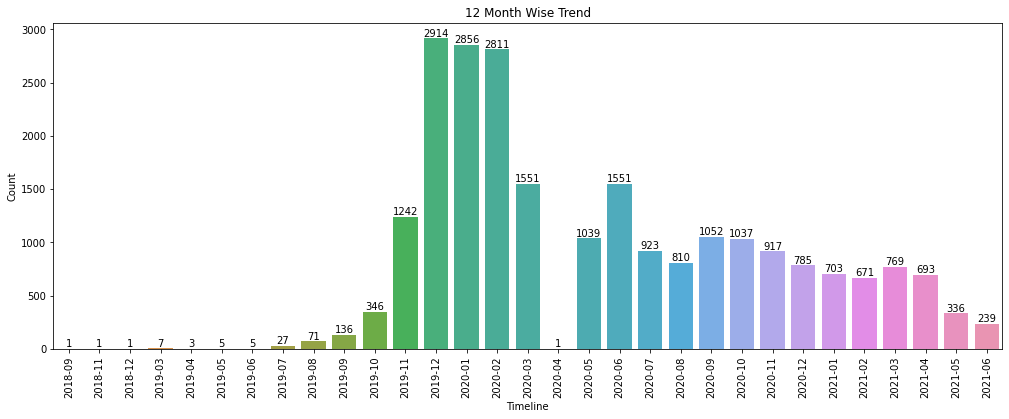

In [43]:
# Plotting 12M trend
plt.figure(figsize=(17,6))

graph = sns.countplot(x ='faultmonth', data = df_12M)
graph.bar_label(graph.containers[0])

plt.xticks(rotation=90, horizontalalignment="center")
plt.title("12 Month Wise Trend")
plt.xlabel("Timeline")

plt.ylabel("Count")
plt.show()